This notebook is advanced version of the [Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost). <br>
We descrive our contribution below pipline 

#### Pipline
* load data
* heal data and remove outliers
* ## (Update) add extra features using shops/items/cats features
* ## (Update) categorize shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month & days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* ## (Update) select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* ##  (Update) fine tuning XGB model and training with GPU
* fit the model, predict and clip targets for the test set

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)

In [5]:
import os
os.listdir()

['[XGB baseline] Advanced Feature Engineering.ipynb',
 'sales_train.csv',
 'Untitled.ipynb',
 'shops.csv',
 'test.csv',
 'item_categories.csv',
 'data.pkl',
 '.ipynb_checkpoints',
 'items.csv',
 'sample_submission.csv']

In [6]:
PATH = 'competitive-data-science-predict-future-sales'
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

print('------------- train info ------------') ; print(train.info(), '\n')
print('------------- test info ------------') ; print(test.info(), '\n')
print('------------- items info ------------') ; print(items.info(), '\n')
print('------------- shops info ------------') ; print(shops.info(), '\n')
print('------------- categories info ------------') ; print(cats.info(), '\n')

------------- train info ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None 

------------- test info ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 2 columns):
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(2)
memory usage: 4.9 MB
None 

------------- items info ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None 

------------- shops info ------------
<clas

## Drop Outliers
check NaN values and below zero values <br>
We drop outliers which price > 10^5 and sales > 1000

In [7]:
print(train.isna().sum(), '\n')
print(test.isna().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64 

shop_id    0
item_id    0
dtype: int64


2
12
2935837


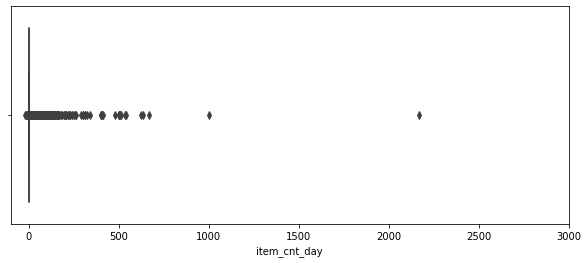

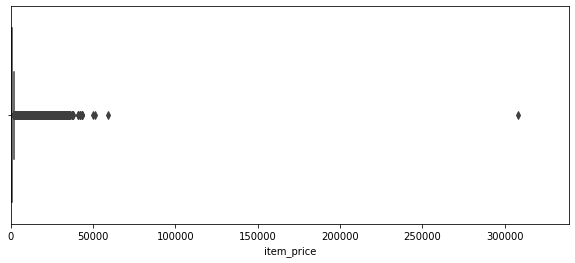

In [8]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

print(len(train[train.item_cnt_day>999]))
print(len(train[train.item_cnt_day>500]))
print(len(train[train.item_cnt_day<501]))

train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

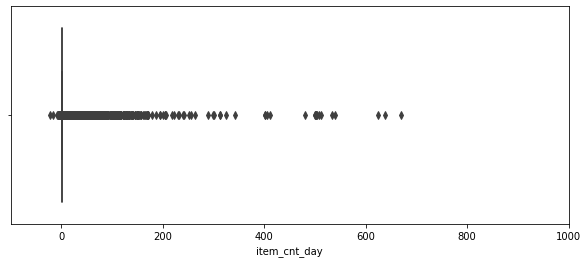

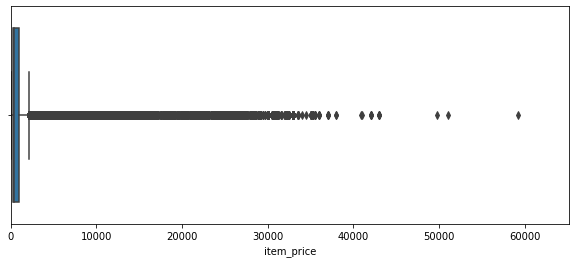

In [9]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 1000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

There is one item with price below zero. Eliminate outlier <br>

Also, there are some negative values in item_cnt_day.<br>
-1.0 : 7252 ,
-2.0 : 78 ,
-3.0 : 14 ,
-4.0 : 3 ,
-5.0 : 4 ,
-6.0 : 2 ,
-9.0 : 1 ,
-16.0 : 1 ,
-22.0 : 1 ,<br>
We decide to change all of them to 0

In [10]:
train = train[train.item_price > 0].reset_index(drop=True)
train[train.item_cnt_day <= 0].item_cnt_day.unique()
train.loc[train.item_cnt_day < 1, 'item_cnt_day'] = 0

Several shops are duplicates of each other (according to its name). Fix train and test set.<br>
We add 40 to 39.

In [11]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 11, 'shop_id'] = 10

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

## Shops dataset preprocessing

In [12]:
shops.shop_name.unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

We categorize subtype of shops in ['Орджоникидзе,' 'ТЦ' 'ТРК' 'ТРЦ', 'ул.' 'Магазин' 'ТК' 'склад' ] <br>
Then transform other values to 'etc'

In [13]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['category'] = shops['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
shops.category = shops.category.apply(lambda x: x if (x in category) else 'etc')
shops.category.unique()

array(['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ', 'etc', 'ул.', 'Магазин', 'ТК',
       'склад'], dtype=object)

In [14]:
shops.groupby(['category']).sum()

,shop_id
category,
etc,68
Магазин,22
"Орджоникидзе,",57
ТК,184
ТРК,140
ТРЦ,340
ТЦ,883
склад,55
ул.,21


However, some categories have small values. So we reduce categories 9 to 5.<br>
['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад', 'etc'] => ['ТЦ', 'ТРК', 'ТРЦ', 'ТК', 'etc']**

In [15]:
category = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shops.category = shops.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', shops.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc           223
ТК            184
ТРК           140
ТРЦ           340
ТЦ            883


In [16]:
shops['shop_city'] = shops.city
shops['shop_category'] = shops.category

shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_category'] = LabelEncoder().fit_transform(shops['shop_category'])

shops = shops[['shop_id','shop_city', 'shop_category']]
shops.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


## Category dataset preprocessing

In [17]:
print(len(cats.item_category_name.unique()))
cats.item_category_name.unique()

84


array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

We think that category 'Игровые консоли' and  'Аксессуары' are same as 'Игры'. <br>
So, we transform the two features to 'Игры'<br>
Also, PC - Гарнитуры/Наушники and 
change to Музыка - Гарнитуры/Наушники <br><br>

In [18]:
cats['type_code'] = cats.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
cats.loc[(cats.type_code == 'Игровые') | (cats.type_code == 'Аксессуары'), 'category'] = 'Игры'
cats.loc[cats.type_code == 'PC', 'category'] = 'Музыка'

category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']

cats['type_code'] = cats.type_code.apply(lambda x: x if (x in category) else 'etc')

print(cats.groupby(['type_code']).sum())
cats['type_code'] = LabelEncoder().fit_transform(cats['type_code'])

cats['split'] = cats.item_category_name.apply(lambda x: x.split('-'))
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

           item_category_id
type_code                  
etc                     236
Игры                    343
Карты                   170
Кино                    195
Книги                   624
Музыка                  345
Подарки                 798
Программы               453
Служебные               159
Чистые                  163


## Category dataset preprocessing <br>
This code get from [1st place solution - Part 1 - "Hands on Data"](https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data). <bt><br>
We use features 'name_2' and 'name_3' below code.

In [20]:
import re
from collections import Counter
from operator import itemgetter

items = pd.read_csv('items.csv')

items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)

def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items['item_name'] = items['item_name'].apply(lambda x: name_correction(x))
items.name_2 = items.name_2.apply(lambda x: x[:-1] if x != '0' else '0')

Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320


Let's create type of item_names. First, cleansing results of name_2. <br>
Concatenate same meaning of types such as, 'x360' & 'xbox360' -> xbox 360 <br>
Three words 'pc' in below code look like same. But, after label encoding they transformed different values.

In [21]:
items['type'] = items.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
items.loc[(items.type == 'x360') | (items.type == 'xbox360'), 'type'] = 'xbox 360'
items.loc[items.type == '', 'type'] = 'mac'
items.type = items.type.apply(lambda x: x.replace(' ',''))
items.loc[(items.type == 'pc') | (items.type == 'pс') | (items.type == 'рс'), 'type'] = 'pc'
items.loc[(items.type == 'рs3'), 'type'] = 'ps3'

group_sum = items.groupby('type').sum()
group_sum.loc[group_sum.item_category_id < 200]

,item_id,item_category_id
type,,
5c5,12118,16
5c7,26808,32
5f4,7936,7
6dv,7934,7
6jv,7924,7
6l6,7935,7
android,12994,78
hm3,7926,7
j72,31709,28


And then, drop types

In [22]:
drop_list = ['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72', 'kf6', 'kf7','kg4',
            'ps2', 's3v', 's4v'	,'англ', 'русская', 'только', 'цифро']

items.name_2 = items.type.apply(lambda x: 'etc' if x in drop_list else x)
items = items.drop(['type'], axis=1)
items.groupby('name_2').sum()

,item_id,item_category_id
name_2,,
0,218310960,872182
etc,253458,550
mac,148743,2323
pc,16991083,106924
ps,431537,1738
ps3,3531772,11422
ps4,895981,3489
psp,692947,2415
xbox360,2362398,10718


In [23]:
items.head()

,item_name,item_id,item_category_id,name_1,name_2,name_3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,коробка,4,40,***КОРОБКА,0,стекло d


In [24]:
items['name_2'] = LabelEncoder().fit_transform(items['name_2'])
items['name_3'] = LabelEncoder().fit_transform(items['name_3'])
items.drop(['item_name', 'name_1'], axis=1, inplace=True)
items.head()

,item_id,item_category_id,name_2,name_3
0,0,40,0,1331
1,1,76,3,42
2,2,40,0,1011
3,3,40,0,1010
4,4,40,0,1572


## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [25]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

14.00943899154663

In [26]:
print(matrix)
train.head()

          date_block_num  shop_id  item_id
114910                 0        2       19
117150                 0        2       27
120623                 0        2       28
118316                 0        2       29
114602                 0        2       32
...                  ...      ...      ...
10697061              33       59    22162
10697251              33       59    22163
10697917              33       59    22164
10699443              33       59    22166
10698738              33       59    22167

[10842077 rows x 3 columns]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.<br>
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/50149#latest-287470

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [27]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [28]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})

group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)#.astype(np.float16))
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

6.502332925796509

## Test set
To use time tricks append test pairs to the matrix.

In [29]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [30]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.16738605499267578

## Shops/Items/Cats features

In [31]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['shop_city'] = matrix['shop_city'].astype(np.int8)
matrix['shop_category'] = matrix['shop_category'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

5.432368278503418

In [32]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_category,item_category_id,name_2,name_3,type_code,subtype_code
0,0,2,19,0.0,0,4,40,0,42,3,4
1,0,2,27,1.0,0,4,19,5,42,1,10
2,0,2,28,0.0,0,4,30,3,42,1,55
3,0,2,29,0.0,0,4,23,8,42,1,16
4,0,2,32,0.0,0,4,40,0,42,3,4


## Traget lags
We use lag_feature : 3

In [33]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [34]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3], 'item_cnt_month')
time.time() - ts

26.300715923309326

## Mean encoded features<br><br>

In [35]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

12.368695974349976

In [36]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

32.26063108444214

In [37]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

31.663743019104004

In [38]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.760799169540405

In [39]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.583253145217896

In [40]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_id'], how='left')
matrix['date_shop_item_avg_item_cnt'] = matrix['date_shop_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_item_avg_item_cnt')
matrix.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

28.30965304374695

In [41]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.131556034088135

In [42]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_city'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.589618921279907

In [43]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

28.187488079071045

In [44]:
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_type_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
# matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
# matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts

In [45]:
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_subtype_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
# matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
# matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts

In [46]:
ts = time.time()
group = matrix.groupby(['date_block_num','shop_id' ,'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id' ,'item_id'], how='left')
matrix['date_shop_item_avg_item_cnt'] = matrix['date_shop_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_item_avg_item_cnt')
matrix.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

30.647830963134766

## Trend Features

In [47]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

337.91621017456055

In [48]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

20.83733630180359

Add month, and days in a month.

In [49]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [50]:
# ts = time.time()
# cache = {}
# matrix['item_shop_last_sale'] = -1
# matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = str(row.item_id)+' '+str(row.shop_id)
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
#         cache[key] = row.date_block_num         
# time.time() - ts

In [51]:
# ts = time.time()
# cache = {}
# matrix['item_last_sale'] = -1
# matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = row.item_id
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         if row.date_block_num>last_date_block_num:
#             matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
#             cache[key] = row.date_block_num         
# time.time() - ts

In [53]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.60782790184021

## Final preparations
Because of the using 3 as lag value drop first 3 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [54]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 3]
time.time() - ts

1.0975632667541504

Producing lags brings a lot of nulls.

In [55]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.1983649730682373

In [56]:
matrix.info()

del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9558812 entries, 1497465 to 11056276
Data columns (total 34 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
shop_city                               int8
shop_category                           int8
item_category_id                        int8
name_2                                  int64
name_3                                  int64
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_shop_avg_item_cnt_lag_1            flo

In [58]:
matrix.to_pickle('data.pkl')

del matrix
gc.collect();

<h3> We recommend creating another notebook to build xgb model because of saving ur time :). <br>

## Build XGB Models (* with GPU *) <br>
If u want to use 'CPU' mode, eliminate argument tree_method='gpu_hist'. (But we recommend 'GPU' mode)

In [59]:
import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [60]:
data = pd.read_pickle('data.pkl')
test  = pd.read_csv('test.csv').set_index('ID')

print(len(data.columns))
data.columns

34


Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_category', 'item_category_id', 'name_2', 'name_3', 'type_code',
       'subtype_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_item_avg_item_cnt_lag_1_x',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_shop_item_avg_item_cnt_lag_1_y', 'delta_price_lag',
       'delta_revenue_lag_1', 'month', 'days', 'item_shop_first_sale',
       'item_first_sale'],
      dtype='object')

Select best features

In [62]:
data = data[[
   'date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_category', 'item_category_id', 'name_2', 'name_3', 'type_code',
       'subtype_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 
#     'date_type_avg_item_cnt_lag_1',
#        'date_subtype_avg_item_cnt_lag_1', 
#     'date_shop_item_avg_item_cnt_lag_1',
    'delta_price_lag',
       'delta_revenue_lag_1', 'month', 'days', 
#     'item_shop_last_sale',
#        'item_last_sale', 
    'item_shop_first_sale', 
    'item_first_sale'
]]

len(data.columns)

32

In [63]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [64]:
del data
gc.collect();

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[16:24:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:59] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12967	validation_1-rmse:1.11815
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.08775	validation_1-rmse:1.07988
[2]	validation_0-rmse:1.05326	validation_1-rmse:1.04846
[3]	validation_0-rmse:1.01713	validation_1-rmse:1.02012
[4]	validation_0-rmse:0.989284	validation_1-rmse:0.999023
[5]	validation_0-rmse:0.966852	validation_1-rmse:0.981679
[6]	validation_0-rmse:0.945749	validation_1-rmse:0.968136
[7]	validation_0-rmse:0.92761	validation_1-rmse:0.95656
[8]	validation_0-rmse:0.912955	validation_1-rmse:0.948446
[9]	valida

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [ ]:
!kaggle competitions submit competitive-data-science-predict-future-sales -f submission.csv -m "second submission"